In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import linear_model
from scipy import stats
from matplotlib import cm
from pathlib import Path
path_noto = Path('../fonts/NotoSansCJKkr-Regular.otf')

from matplotlib import font_manager
# font_manager.fontManager.addfont(path_noto)
plt.rc('font', family='Malgun Gothic')

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f5f5f5'
warnings.filterwarnings('ignore')

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


In [2]:
df = pd.read_csv('./bike.csv')
# df.drop(columns=["운동량", "탄소량", "이동거리(M)"], inplace=True)
df['연령대'].unique()

array(['50대', '20대', '60대', '40대', '10대', '30대', '70대이상'], dtype=object)

In [11]:
# To be exported
exp = df.drop(df[df['요금제'] == '일일(비회원)'].index) # 비회원 빼기
exp.drop(exp[exp['요금제'] == '10분이용권'].index, inplace=True) # 10분 이용권 빼기
exp.drop(exp[exp['연령대'] == '기타'].index, inplace=True) # 기타 빼기
exp['요금제'] = exp['요금제'].str.replace('\(회원\)', '') # 일일(회원) -> 일일

exp['성별'] = exp['성별'].str.upper() # m, f -> M, F
exp['성별'] = exp['성별'].str.replace('M', '남성')
exp['성별'] = exp['성별'].str.replace('F', '여성')

exp['운동량'] = exp['운동량'].replace('\\N', np.NaN).astype(float) # \N -> NaN, convert to float
exp['탄소량'] = exp['탄소량'].replace('\\N', np.NaN).astype(float) # \N -> NaN, convert to float

exp['1건당 운동량'] = exp['이용건수'] / exp['운동량'] # 1건당 운동량 컬럼 생성

# exp.head()

filepath = Path('./bike.csv')
exp.to_csv(filepath, index=False, encoding='utf-8-sig')

In [3]:
# 전처리
df = df.dropna()
df.head()

,요금제,성별,연령대,이용건수,운동량,탄소량,이동거리(M),1건당 이용시간,1건당 운동량
0,일일,남성,50대,19,458.11,4.44,19280.00,6.157895,0.041475
1,정기,여성,20대,12,330.13,3.39,14626.81,6.250000,0.036349
3,정기,남성,20대,2,13.69,0.07,320.00,2.000000,0.146092
4,정기,남성,40대,12,622.21,4.54,19557.91,10.000000,0.019286
5,정기,남성,50대,12,684.05,5.70,24518.37,24.416667,0.017543


In [4]:
colors = sns.color_palette('pastel')[0:7]
df.head(10)

,요금제,성별,연령대,이용건수,운동량,탄소량,이동거리(M),1건당 이용시간,1건당 운동량
0,일일,남성,50대,19,458.11,4.44,19280.00,6.157895,0.041475
1,정기,여성,20대,12,330.13,3.39,14626.81,6.250000,0.036349
3,정기,남성,20대,2,13.69,0.07,320.00,2.000000,0.146092
4,정기,남성,40대,12,622.21,4.54,19557.91,10.000000,0.019286
5,정기,남성,50대,12,684.05,5.70,24518.37,24.416667,0.017543
6,정기,남성,60대,4,146.80,1.18,5078.18,36.750000,0.027248
7,일일,남성,40대,15,1573.39,13.56,58430.19,21.933333,0.009534
12,단체,여성,10대,1,120.51,1.09,4681.84,82.000000,0.008298
13,단체,여성,20대,5,453.62,4.09,17622.86,30.400000,0.011022
14,단체,여성,30대,4,257.60,2.32,10007.82,35.750000,0.015528


## EDA 1

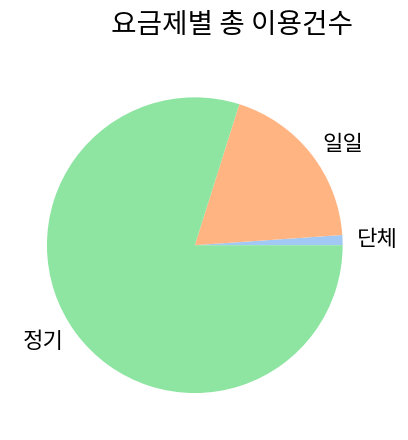

In [38]:
# df.drop(columns=["운동량", "탄소량", "이동거리(M)"], inplace=True)
pie_mem = df.groupby('요금제')['이용건수'].sum()
pie_mem_exp = pie_mem.reset_index() # bike_eda1.csv로 export
fig, ax = plt.subplots()
ax.pie(pie_mem, labels=pie_mem.index, colors=colors, textprops={'font':path_noto, 'fontsize':16})
ax.set_title("요금제별 총 이용건수", font=path_noto, fontsize=20, x=0.6)
plt.show()

In [40]:
pie_mem_exp.columns = ['요금제', '총 이용건수']
pie_mem_exp

,요금제,총 이용건수
0,단체,27247
1,일일,471466
2,정기,1977847


In [62]:
filepath = Path('./bike_eda1.csv')
pie_mem_exp.to_csv(filepath, index=False, encoding="utf-8-sig")

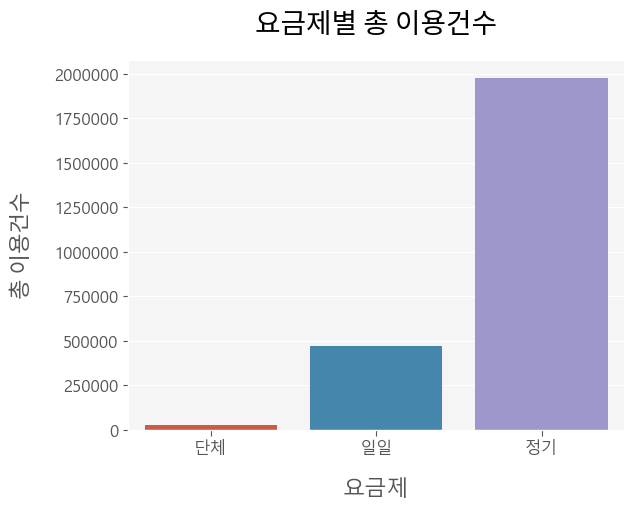

In [42]:
fig, ax = plt.subplots()

ax = sns.barplot(data=pie_mem_exp, x='요금제', y='총 이용건수', ci=None)
ax.set_title("요금제별 총 이용건수", font=path_noto, fontsize=20)
ax.set_ylabel("총 이용건수", font=path_noto, fontsize=16)
ax.set_xlabel("요금제", fontsize=16)
ax.ticklabel_format(axis='y', style='plain')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## EDA 2 & 3

         이용건수   1건당 이용시간
성별                      
F   31.304044  30.030200
M   42.984368  27.232428


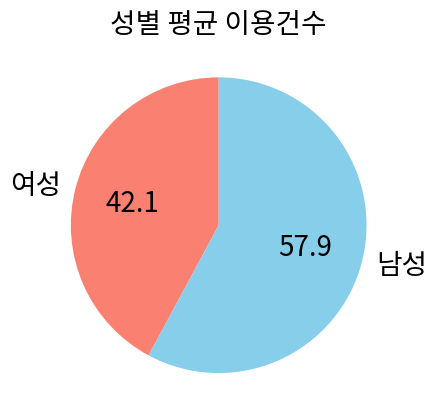

In [8]:
pie_eda2 = df.groupby('성별')[['이용건수', '1건당 이용시간']].mean()
print(pie_eda2)

def absolute_value(val):
    a  = np.round(val/100.*pie_eda2['1건당 이용시간'].sum(), 0)
    return a

plt.title("성별 평균 이용건수", font=path_noto, fontsize=20)
plt.pie(pie_eda2['이용건수'].values, labels=['여성', '남성'], startangle=90, autopct='%.1f', colors=['salmon', 'skyblue'], textprops={'font':path_noto, 'fontsize':20})
plt.show()

In [9]:
filepath = Path('./bike_eda2.csv')
pie_eda2_exp = df.groupby('성별')[['이용건수', '1건당 이용시간']].sum()
# print(pie_eda2_exp.head())
# print(df['성별'].value_counts())

pie_eda2_exp['총 인원'] = df['성별'].value_counts().values
pie_eda2_exp.columns = ['이용건수 총계', '1건당 이용시간 총계', '총 인원']
pie_eda2_exp.head()
pie_eda2_exp.to_csv(filepath, index=False, encoding="utf-8-sig")

## EDA 4

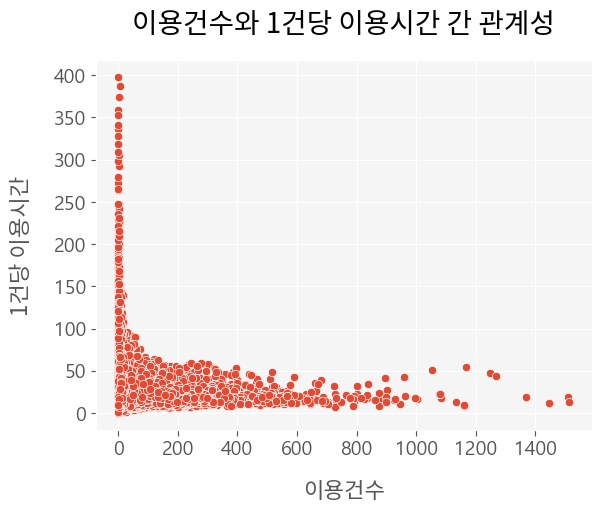

In [45]:
fig, ax = plt.subplots()

ax = sns.scatterplot(data=df, x='이용건수', y='1건당 이용시간')
ax.set_title("이용건수와 1건당 이용시간 간 관계성", font=path_noto, fontsize=20, pad=20)
ax.set_xlabel("이용건수", font=path_noto, fontsize=16, labelpad=15)
ax.set_ylabel("1건당 이용시간", font=path_noto, fontsize=16, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## EDA 5 & 6

In [23]:
df_age = df.sort_values(by='연령대')
df_age_grouped = df_age.groupby('연령대')['1건당 이용시간'].sum().reset_index()
df_age_grouped.columns=['연령대', '1건당 이용시간 총계']
df_age_grouped['총 인원'] = df_age['연령대'].value_counts().reset_index().sort_values(by='index')['연령대'].values
df_age_grouped['1건당 이용시간 총계'] = df_age_grouped['1건당 이용시간 총계'].astype(int)
df_age_grouped

,연령대,1건당 이용시간 총계,총 인원
0,10대,282316,11137
1,20대,303200,12070
2,30대,323625,11656
3,40대,386957,12025
4,50대,303238,9768
5,60대,205126,6630
6,70대이상,80235,2772


In [24]:
df_age_mean = df_age.groupby('연령대')['1건당 이용시간'].mean().reset_index()
df_age['연령대'].value_counts().reset_index().sort_values(by='index')['연령대']

3    11137
0    12070
2    11656
1    12025
4     9768
5     6630
6     2772
Name: 연령대, dtype: int64

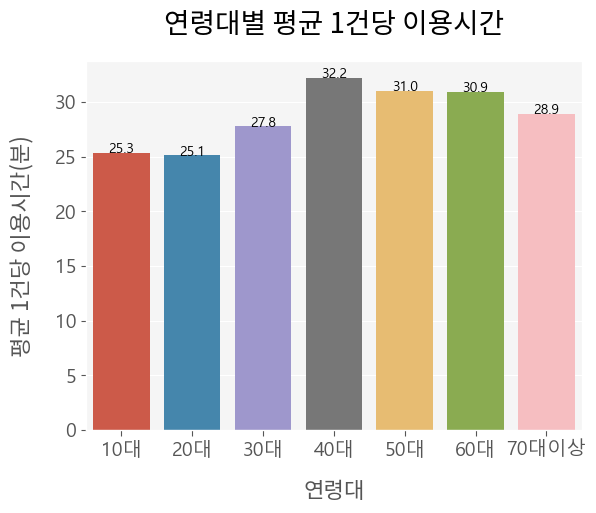

In [44]:
fig, ax = plt.subplots()

ax = sns.barplot(data=df_age_mean, x='연령대', y='1건당 이용시간', ci=None)
ax.set_title('연령대별 평균 1건당 이용시간', font=path_noto, fontsize=20)
ax.set_xlabel('연령대', font=path_noto, fontsize=16)
ax.set_ylabel('평균 1건당 이용시간(분)', font=path_noto, fontsize=16)

# for i in ax.containers:
#     ax.bar_label(tmp)

for index, row in df_age_mean.iterrows():
    ax.text(row.name, row['1건당 이용시간'], round(row['1건당 이용시간'], 1), color='black', ha='center')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [14]:
filepath = Path('./bike_eda5.csv')
df_age_grouped.to_csv(filepath, index=False, encoding="utf-8-sig")

In [4]:
xx = pd.read_csv("./bike_eda5.csv")
xx['평균 1건당 이용시간'] = xx['1건당 이용시간 총계'] / xx['총 인원']
filepath = Path('./bike_eda5.csv')
xx.to_csv(filepath, index=False, encoding='utf-8-sig')

In [35]:
import matplotlib
matplotlib.rcParams['axes.labelpad'] = 15
matplotlib.rcParams['axes.titlepad'] = 20